In [1]:
#import os
#os.add_dll_directory("D:\\3rd_party\\deps\\ffmpeg-n5.0-latest-win64-gpl-shared-5.0\\bin")
#os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v12.3/bin")

<AddedDllDirectory('C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v12.3/bin')>

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
#src = r"D:\repos\opencv\extra\testdata\highgui\video\big_buck_bunny.mp4"
src = "big_buck_bunny.mp4"

Notes
1. 10 Bit formats and YUV444 are output as YUV (color conversion routines still to come)
2. Both formats can be forced to 8 bit on read.  YUV444_10BIT->YUV444 and YUV420_10BIT->BGRA (because existing color conversion deals with NV12)
3. VideoWriter currently outputs limited chroma range mp4 files (video_full_range_flag=false).  The conversion is automatic if you use BGR input however if you use YUV there will be no conversion so you should manually perform the conversion first if you want to play back the video without "color shift".  If you just intend to read back the luminance in cudacodec::VideoReader this isn't a problem because it outputs raw YUV values but if you intend to watch it (read BGR etc.) you need to convert you YUV values to the limited range before encoding.

# YUV420

In [3]:
def check420(color_format, force_8_bit_output = True):
    reader = cv.cudacodec.createVideoReader(src)
    reader.set(cv.cudacodec.ColorFormat_NV_NV12)
    fmt = reader.format()
    writer = cv.cudacodec.createVideoWriter('output.mp4', fmt.targetSz, codec=cv.cudacodec.HEVC, fps=30,
                                            colorFormat=color_format)
    ret, frame = reader.nextFrame()
    for i in range(100):
        if(color_format ==  cv.cudacodec.ColorFormat_NV_YUV420_10BIT):
            frame_yuv_out_type = frame.convertTo(cv.CV_16U)
            frame_yuv_out_type = cv.cuda.lshift(frame_yuv_out_type, 8)
            #type = cv.CV_16U
        else:
            frame_yuv_out_type = frame
            #type = cv.CV_8U
        writer.write(frame_yuv_out_type)
        reader.nextFrame(frame)
    writer.release()
    params = cv.cudacodec.VideoReaderInitParams()
    params.output16Bit = False if force_8_bit_output else True
    reader = cv.cudacodec.createVideoReader('output.mp4',params=params)
    ret, frame = reader.nextFrame()
    if(force_8_bit_output or color_format == cv.cudacodec.ColorFormat_NV_NV12):
        assert reader.format().outputFormat == cv.cudacodec.ColorFormat_NV_NV12
        assert frame.type() == cv.CV_8UC4
    else:
        assert reader.format().outputFormat==color_format
        assert frame.type() == cv.CV_16U
    plt.imshow(frame.download())

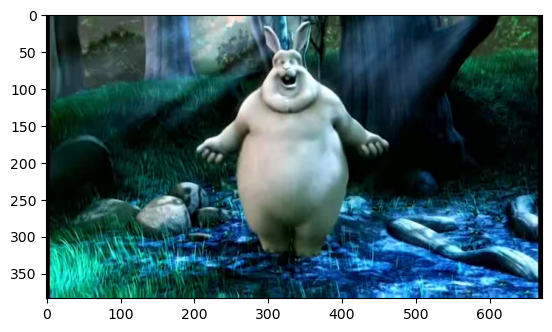

In [4]:
check420(cv.cudacodec.ColorFormat_NV_NV12, True)

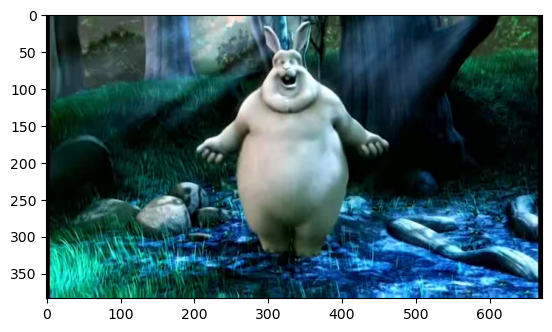

In [5]:
check420(cv.cudacodec.ColorFormat_NV_NV12, False)

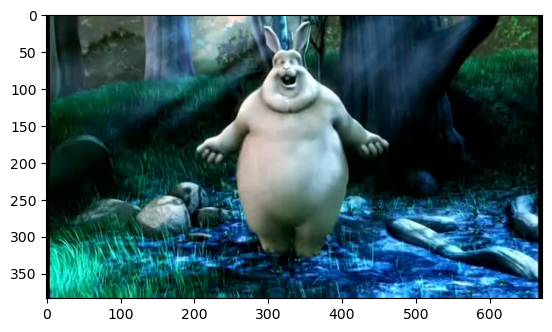

In [6]:
check420(cv.cudacodec.ColorFormat_NV_YUV420_10BIT, True)

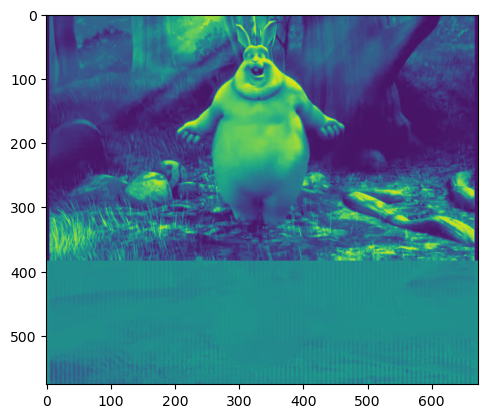

In [7]:
check420(cv.cudacodec.ColorFormat_NV_YUV420_10BIT, False)

## YUV444

In [8]:
def bgrToYuv444(frame_bgr, color_format):
    cols, rows = frame_bgr.size()
    frame_yuv = cv.cuda.cvtColor(frame_bgr,cv.COLOR_BGR2YUV)
    if(color_format == cv.cudacodec.ColorFormat_NV_YUV444_10BIT):
        frame_yuv_out_type = frame_yuv.convertTo(cv.CV_16U)
        type = cv.CV_16U
    else:
        frame_yuv_out_type = frame_yuv
        type = cv.CV_8U
    yuv = cv.cuda.split(frame_yuv_out_type)
    frame_yuv444 = cv.cuda_GpuMat(rows*3,cols,type)
    for i in range(3):
        yuv[i].copyTo(dst=frame_yuv444.rowRange(i*rows,(i+1)*rows))
    if(frame_yuv444.type() == cv.CV_16U):
        cv.cuda.lshift(frame_yuv444, 8, dst=frame_yuv444)
    return frame_yuv444

In [9]:
def check444(color_format, force_8_bit_output = True):
    reader = cv.cudacodec.createVideoReader(src)
    reader.set(cv.cudacodec.ColorFormat_BGR)
    fmt = reader.format()
    writer = cv.cudacodec.createVideoWriter('output.mp4', fmt.targetSz, codec=cv.cudacodec.HEVC, fps=30,
                                            colorFormat=color_format)
    ret, frame = reader.nextFrame()
    for i in range(100):
        frame_yuv444 = bgrToYuv444(frame, color_format)
        writer.write(frame_yuv444)
        reader.nextFrame(frame)
    writer.release()
    params = cv.cudacodec.VideoReaderInitParams()
    params.output16Bit = False if force_8_bit_output else True
    reader = cv.cudacodec.createVideoReader('output.mp4',params=params)
    ret, frame = reader.nextFrame()
    if(force_8_bit_output or color_format == cv.cudacodec.ColorFormat_NV_YUV444):
        assert reader.format().outputFormat == cv.cudacodec.ColorFormat_NV_YUV444
        assert frame.type() == cv.CV_8U
    else:
        assert reader.format().outputFormat==color_format
        assert frame.type() == cv.CV_16U
    print(reader.format().outputFormat)
    plt.imshow(frame.download())

10


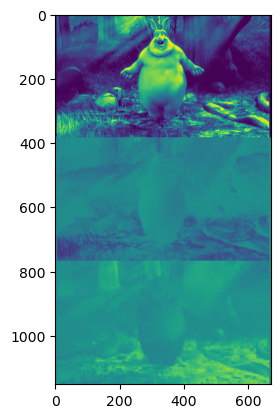

In [10]:
check444(cv.cudacodec.ColorFormat_NV_YUV444, True)

10


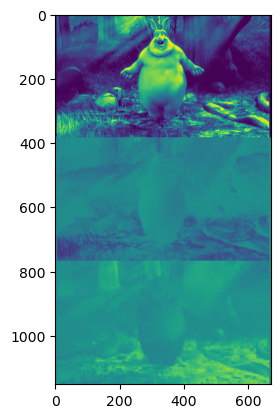

In [11]:
check444(cv.cudacodec.ColorFormat_NV_YUV444, False)

10


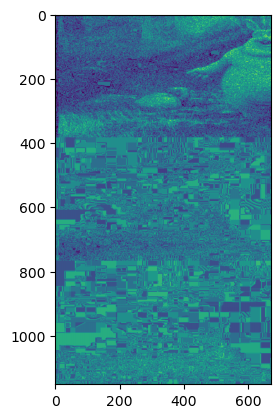

In [12]:
# Not working ignore untill color format conversion is added
check444(cv.cudacodec.ColorFormat_NV_YUV444_10BIT, True)

16


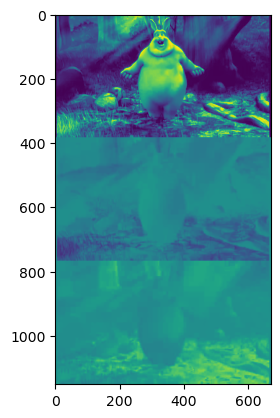

In [13]:
check444(cv.cudacodec.ColorFormat_NV_YUV444_10BIT, False)